# UDA: Machine Learning Research Topic Analysis in 2023  
This notebook was developed on a MacBook Pro 2.6Ghz 6-core Intel Core i7, 16GB 2667MHz DDR4.  
The compute time on this device for the entire notebook ~ 10 mins (or ~ 20 mins including arXiv download)  

# 1. Data Selection

## 1.1 Download arXiv Machine Learning Abstracts
ref: https://info.arxiv.org/help/api/user-manual.html  
Source the most recent set of Machine Learning paper abstracts (going back 1 year).  
Note it is safe to execute this cell as the very long running query is switched off and the pre-loaded data can be read from a csv in the subsequent cell.  

In [1]:
import requests
import feedparser
import pandas as pd
import numpy as np 

np.random.seed(30224)

# WARNING: can take > 10 mins 
# Sourcing 1 Year of raw abstract data. For Info ONLY on how to retrieve data. Raw Data has been saved as a csv and is loaded in the next cell 
# SWITCHED OFF!
if (False):

    # Function to fetch most recent abstracts from arXiv: Ref: https://info.arxiv.org/help/api/user-manual.html
    def fetch_entries(start, max_results):
        query = 'cat:cs.LG'  # Machine Learning category
        url = f'http://export.arxiv.org/api/query?search_query={query}&start={start}&max_results={max_results}&sortBy=submittedDate&sortOrder=descending'
        response = requests.get(url)
        feed = feedparser.parse(response.content)
        return feed.entries

    # Function to convert downloaded abstracts to Data Frame objects
    def build_df(entries):
        abstracts = []
        dates = []
        for entry in entries:
            abstracts.append(entry.summary)
            dates.append(entry.published)
        return(pd.DataFrame({'abstract': abstracts, 'date': dates}) )

    # List to store each batch DataFrame
    dfs = []
    batch_size = 5000
    # Total number of batches
    total_batches = 7

    for batch in range(total_batches):
        start_index = batch * batch_size
        entries = fetch_entries(start_index, batch_size)
        df = build_df(entries)
        dfs.append(df)

    # Concatenate the abstract data frames and cuttof data frame to results after 1st Jan 2023 
    df_all = pd.concat(dfs, axis=0, ignore_index=True)  
    df_all['date'] = pd.to_datetime(df_all['date']).dt.tz_localize(None)
    df_all = df_all[df_all['date'] >= pd.to_datetime('2023-01-01')]
    df_all.to_csv("raw_arxiv_abstracts_1Y.csv", index=False)
     

## 1.2 Load pre-saved arXiv abstracts & wikipedia definitions  
Abstracts are already saved in the file *raw_arxiv_abstracts_1Y.csv*  and ML approaches/paradigms are saved in *wiki_main_ml_topics.csv*  
Note:  
Machine Learning 'paradigm definitions' are sourced from:  Wikipedia  https://en.wikipedia.org/wiki/Machine_learning#Approaches   
Machine Learning 'model definitions' are sourced from:  Wikipedia  https://en.wikipedia.org/wiki/Machine_learning#Models and https://en.wikipedia.org/wiki/Large_language_model  

In [2]:
# assumes csv is in same directory as the ipynb notebook
raw_abstracts = pd.read_csv("raw_arxiv_abstracts_1Y.csv")   
raw_abstracts['date'] = pd.to_datetime(raw_abstracts['date']).dt.tz_localize(None)
print(raw_abstracts)
# pre-saved wikipedia 'definitions' of the main types of machine learning paradigms {'supervised','unsupervised', 'reinforcement'}
wiki_main_topics = pd.read_csv("wiki_main_ml_topics.csv")
print(wiki_main_topics)
# pre-saved wikipedia MODEL 'definitions' of the main types of machine learning model {llm, ann, dtree, svm, regr, bayes, gp, ga, belief, federated}
wiki_main_ml_models = pd.read_csv("wiki_main_ml_models.csv")
wiki_main_ml_models = wiki_main_ml_models[['ml_type', 'topic']]
print(wiki_main_ml_models)

                                                abstract                date
0      Molecular abundances in protoplanetary disks a... 2023-12-08 18:59:22
1      We develop a generative attention-based approa... 2023-12-08 18:59:14
2      Deep learning models are often deployed in dow... 2023-12-08 18:59:03
3      Decentralised learning has recently gained tra... 2023-12-08 18:55:40
4      There are various applications, where companie... 2023-12-08 18:32:27
...                                                  ...                 ...
30854  Despite its importance for federated learning,... 2023-01-01 02:33:03
30855  The usage of technologically advanced devices ... 2023-01-01 02:18:02
30856  This work studies training one-hidden-layer ov... 2023-01-01 02:11:39
30857  Vertical Federated Learning (VFL) is widely ut... 2023-01-01 02:03:34
30858  We derive a set of causal deep neural networks... 2023-01-01 00:47:03

[30859 rows x 2 columns]
         ml_type                                  

# 2. Data Preprocessing  

# 2.1 Preprocess the arXiv Abstracts  
-   convert to lower case  
-   remove symbols (but keep numbers which could indicate dimensionality and so be useful)  
-   remove very common words and new line characters   
-   tokenise  
-   remove stop words  
-   apply stemming  

In [3]:
# Clean the Abstracts
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import * 

# Function to clean documents, remove stop words, apply stemming and tokenise
def preprocess(docs):
    # General string cleaning

    # convert to lower case 
    docs = docs.str.lower()
    # Remove symbols (keep alphanumeric characters and spaces)
    docs = docs.str.replace('[^\w\s]', '', regex=True)
    # Replace multiple spaces with a single space
    docs = docs.str.replace('\s+', ' ', regex=True)
    # Remove newline characters 
    docs = docs.replace("\n", " ")
    # Remove common words  
    remove_list = ["learning","model", "method", "data", "dataset", "compute", "show", "algorithm", "train", "perform", "problem", "optimize", "result","supervised","unsupervised"]
    for word in remove_list:
        docs = docs.str.replace(word, " ")
    
    #Tokensization 
    docs_tok = docs.apply(lambda x: x.split())
    # Stemming and removing English stop words 
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    docs_tok = docs_tok.apply(lambda x: [stemmer.stem(i) for i in x if i not in stop_words])

    return(docs_tok)

nltk.download('stopwords') 
abstracts = raw_abstracts['abstract']
abstracts_tok = preprocess(abstracts)
abstracts_tok.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stephenhope/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    [molecular, abund, protoplanetari, disk, highl...
1    [develop, gener, attentionbas, approach, ing, ...
2    [deep, often, deploy, downstream, task, ing, p...
3    [decentralis, recent, gain, traction, altern, ...
4    [variou, applic, compani, need, decid, individ...
Name: abstract, dtype: object

# 2.2 Preprocess the Wikipedia 'Definitions' of Main ML Paradigms    
Apply the same preprocessing steps to the Wikipedia definitions as was applied to the ArXiv abstracts.  

In [4]:
# Wikipedia 'definitions' of main ML approaches 
wiki_supervised_tok = preprocess(wiki_main_topics.loc[wiki_main_topics['ml_type'] == 'supervised', 'topic'])
wiki_unsupervised_tok = preprocess(wiki_main_topics.loc[wiki_main_topics['ml_type'] == 'unsupervised', 'topic'])
wiki_reinforcement_tok = preprocess(wiki_main_topics.loc[wiki_main_topics['ml_type'] == 'reinforcement', 'topic'])

# 3. Latent Dirichlet Allocation (LDA) on Machine Learning Topics   
Perform LDA on the 30k+ 2023 abstracts assuming 3 main topics  

In [5]:
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import TfidfModel

# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(abstracts_tok)
# Filter out words that occur in less than 15 documents, or more than 50% of the documents
dictionary.filter_extremes(no_below=15, no_above=0.5)
# Convert document into the bag-of-words (BoW) format
corpus = [dictionary.doc2bow(text) for text in abstracts_tok]
tfidf_model = TfidfModel(corpus)

# Assume 3 main topics
num_topics = 3
passes = 10
# Create an LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes, random_state=123)
# Print the topics
dictionary_size = len(dictionary)
print("Size of dictionary:", dictionary_size)
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Size of dictionary: 6125
Topic: 0 
Words: 0.010*"task" + 0.008*"gener" + 0.008*"system" + 0.007*"languag" + 0.006*"approach" + 0.006*"ing" + 0.006*"anc" + 0.005*"polici" + 0.005*"evalu" + 0.005*"research"
Topic: 1 
Words: 0.011*"imag" + 0.010*"predict" + 0.009*"featur" + 0.009*"ing" + 0.009*"gener" + 0.008*"anc" + 0.007*"task" + 0.007*"network" + 0.007*"detect" + 0.007*"approach"
Topic: 2 
Words: 0.013*"network" + 0.010*"ing" + 0.009*"neural" + 0.009*"optim" + 0.008*"function" + 0.007*"gener" + 0.007*"distribut" + 0.006*"sampl" + 0.006*"comput" + 0.006*"graph"


## 3.1 Show Top 10 Words for each of the 3 Topic Distributions    

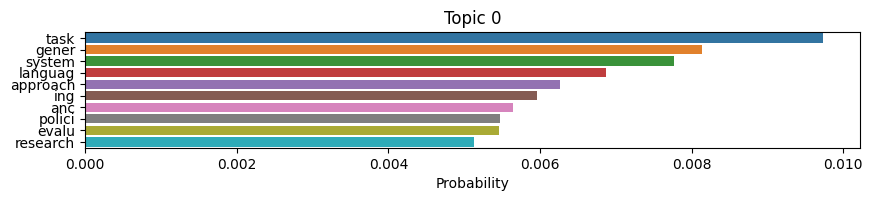

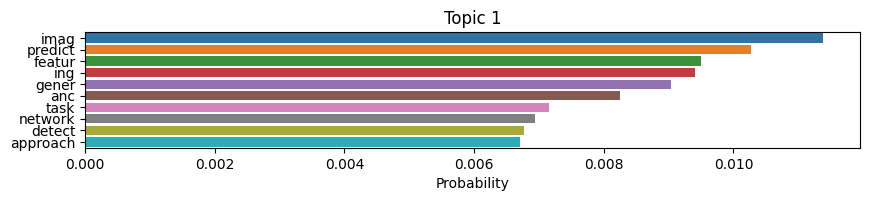

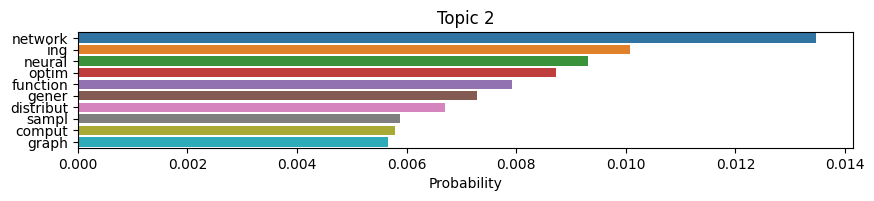

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

top_words_per_topic = []
for t in range(lda_model.num_topics):
    top_words_per_topic.extend([(t, ) + x for x in lda_model.show_topic(t, topn = 10)])

df_top_words = pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'Probability'])

for i in range(lda_model.num_topics):
    fig, ax = plt.subplots(figsize=(10, 1.5))  
    topic_words = df_top_words.loc[df_top_words['Topic'] == i]
    sns.barplot(x='Probability', y='Word', data=topic_words, ax=ax)
    ax.set_title(f'Topic {i}')
    ax.set_xlabel('Probability')
    ax.set_ylabel('')
    plt.show()


## 3.2 Wikipedia ML 3 Paradigm Definition Mapping  
Using the definitions for the 3 main ML paradigms {supervised, unsupervised, reinforcement}, find the topic distributions for each wikipedia definition. That is, the topic distribution is the proportion of each topic from the LDA model found in that definition doc. Note it does not give a probability of the definition belonging to the LDA topic in a strict sense. LDA is measuring mixed membership distributions in that a single document can have portions belonging to multiple topics.   

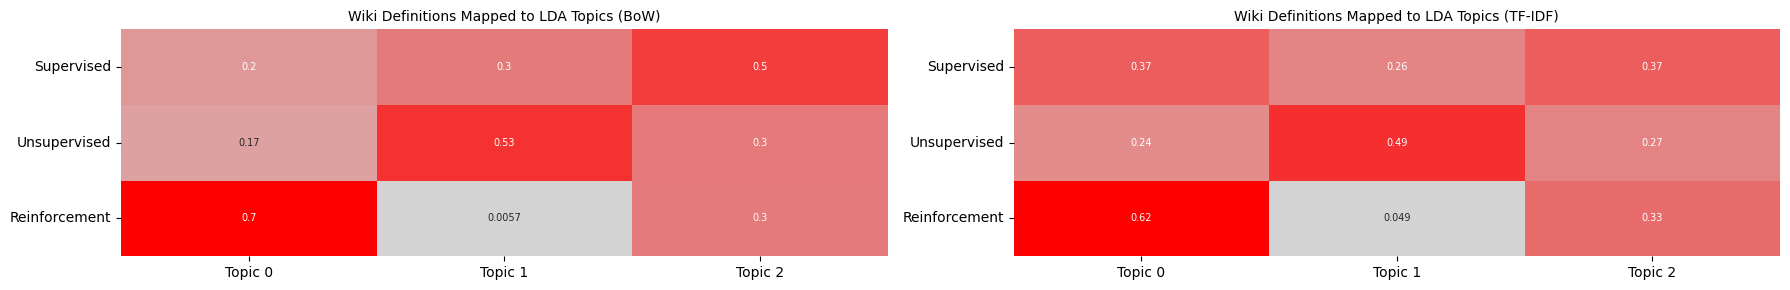

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Function to get the topic distribution for each user doc supplied (defns here)  
def get_topic_distribution(the_lda_model, defns, n_topics, model='bow'):
    topic_matrix = np.zeros((len(defns), n_topics))
    # Loop over each definition
    for i, defn in enumerate(defns):
        # Convert the definition to a BoW format
        bow = dictionary.doc2bow(defn)
        # Get the topic distribution
        if (model == 'bow'):
            topic_distribution = the_lda_model.get_document_topics(bow, minimum_probability=0)
        else:
            # Transform BoW to TF-IDF
            tfidf = tfidf_model[bow]
            topic_distribution = the_lda_model.get_document_topics(tfidf)

        # Fill the matrix with topic probabilities
        for topic_id, prob in topic_distribution:
            topic_matrix[i, topic_id] = prob
    return(topic_matrix)

# Wikipedia 'definitions' of topics
wiki_defns = [wiki_supervised_tok.iloc[0], wiki_unsupervised_tok.iloc[0], wiki_reinforcement_tok.iloc[0]]
# Initialize an empty matrix to store topic probabilities
topic_matrix_wiki_bow = get_topic_distribution(lda_model, wiki_defns, lda_model.num_topics)
topic_matrix_wiki_tfidf = get_topic_distribution(lda_model, wiki_defns, lda_model.num_topics, model='tfidf')


# Plots
row_labels = ['Supervised', 'Unsupervised', 'Reinforcement']
col_labels = [f'Topic {i}' for i in range(lda_model.num_topics)]
cmap = LinearSegmentedColormap.from_list('grey_red', ['lightgrey', 'red'])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 3))  

# Plot for BoW
sns.heatmap(topic_matrix_wiki_bow, annot=True, cmap=cmap, xticklabels=col_labels, yticklabels=row_labels, cbar=False, annot_kws={"size": 7}, ax=axes[0])
axes[0].set_title('Wiki Definitions Mapped to LDA Topics (BoW)', fontsize=10)
axes[0].tick_params(axis='x', labelrotation=0, labelsize=10)
axes[0].tick_params(axis='y', labelsize=10)

# Plot for TF-IDF
sns.heatmap(topic_matrix_wiki_tfidf, annot=True, cmap=cmap, xticklabels=col_labels, yticklabels=row_labels, cbar=False, annot_kws={"size": 7}, ax=axes[1])
axes[1].set_title('Wiki Definitions Mapped to LDA Topics (TF-IDF)', fontsize=10)
axes[1].tick_params(axis='x', labelrotation=0, labelsize=10)
axes[1].tick_params(axis='y', labelsize=10)

plt.tight_layout()
plt.show()


## 3.3 Estimate Number of Abstracts per Topic over 2023  
To make the estimate using LDA (with BoW), assume that the largest 'proportion' of the Wikipedia definition mapping above is telling us {Topic 0 = reinforcement, Topic 1 = supervised, Topic 2 = unsupervised}  
Then, find the dominant Topic by probability from the LDA model for each abstract and map to the Wikipedia definition labels      

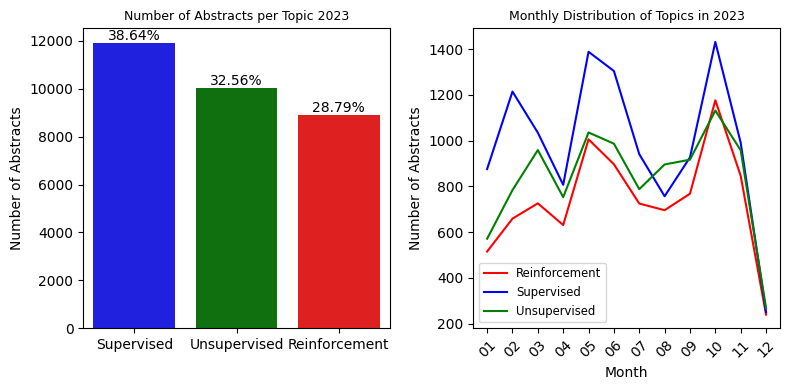

In [9]:
# Function to find the topic distribution for each abstract
def topic_distribution(the_lda_model):
    dominant_topics = []
    for i, row_list in enumerate(the_lda_model[corpus]):
        row = row_list[0] if the_lda_model.per_word_topics else row_list            
        # Sort the topics by probability
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the dominant topic
        dominant_topic = row[0][0]
        dominant_topics.append(dominant_topic)

    # Add dominant topics to a DataFrame
    df_topic_distribution = pd.DataFrame()
    df_topic_distribution['Dominant_Topic'] = dominant_topics
    # Count the number of abstracts per topic
    topic_counts = df_topic_distribution['Dominant_Topic'].value_counts()
    # Convert to DataFrame for easy plotting
    df_topic_counts = pd.DataFrame(topic_counts).reset_index()
    df_topic_counts.columns = ['Topic', 'Num_Documents']
    # Assign wikipedia topic names based on the mapping found above 
    if (df_topic_counts.shape[0] == 3): 
        topic_names = {0: 'Reinforcement', 1: 'Unsupervised', 2: 'Supervised'}
        # Replace topic numbers with the proposed topic mapping 
        df_topic_counts['Topic'] = df_topic_counts['Topic'].map(topic_names)
    total_abstracts = len(abstracts_tok)
    df_topic_counts['Percentage'] = (df_topic_counts['Num_Documents'] / total_abstracts) * 100

    return total_abstracts, df_topic_counts, dominant_topics

# Get topic distributions of the abstracts
total_abstracts, df_topic_counts, dominant_topics = topic_distribution(lda_model)

# Plots 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
palette = {'Supervised': 'blue', 'Unsupervised': 'green', 'Reinforcement': 'red'}
# First Plot: Bar plot
bar_plot = sns.barplot(x='Topic', y='Num_Documents', data=df_topic_counts, ax=ax[0], palette=palette)
bar_plot.grid(False)
ax[0].set_title('Number of Abstracts per Topic 2023', fontsize=9)
ax[0].set_xlabel('')
ax[0].set_ylabel('Number of Abstracts')

# Annotate bars with the percentage
for p in bar_plot.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height() / total_abstracts)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    bar_plot.annotate(percentage, (x, y), ha='center', va='bottom')

# Second Plot: Line plot showing evolution of topic research over the year 
# Add date column to abstract_tok 
abstracts_tok_ = pd.DataFrame({'topic': abstracts_tok, 'date': raw_abstracts['date']})
abstracts_tok_['Month'] = pd.to_datetime(abstracts_tok_['date']).dt.to_period('M')
abstracts_tok_['Dominant_Topic'] = dominant_topics  
# Replace numeric topic IDs with names
topic_names = {0: 'Reinforcement', 1: 'Unsupervised', 2: 'Supervised'}
abstracts_tok_['Dominant_Topic'] = abstracts_tok_['Dominant_Topic'].map(topic_names)
# Group by month and topic
monthly_topic_counts = abstracts_tok_.groupby(['Month', 'Dominant_Topic']).size().reset_index(name='Num_Documents')
monthly_topic_counts['Month'] = monthly_topic_counts['Month'].dt.strftime('%m')

sns.lineplot(x='Month', y='Num_Documents', hue='Dominant_Topic', data=monthly_topic_counts, ax=ax[1],palette=palette)
ax[1].set_title('Monthly Distribution of Topics in 2023', fontsize=9)
ax[1].set_ylabel('Number of Abstracts')
ax[1].set_xlabel('Month')
ax[1].tick_params(axis='x', rotation=45)
ax[1].legend(fontsize='small')

# Show the plots
plt.tight_layout()
plt.show()


# 4. Agglomerative Heirarchical Clustering of ML Topics  
It is desirable to have some estimate of the optimum number of topics to train the LDA model on. This can be achieved by performing hierarchical agglomerative clustering using the ward function from scipy.  

First the abstracts tokens are converted to a TF-IDF representation so that a distance matrix can be calculated.  
However given the computational cost of performing hierarchical agglomerative clustering on a laptop with a matrix of size of approximately $\mathbb{R}^{30000 \times 25000}$ , instead, a random sample of 6000 rows of the TF-IDF matrix is taken to be representative of the topic structure of the abstracts.  

## 4.1 Compute the Distance Matrix  

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Join the tokenized words into strings
abstracts_str = abstracts_tok.apply(' '.join)

# Create a TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(abstracts_str)
# Reduce the size for computation for tractability on a laptop
num_samples = 6000 
np.random.seed(123)
random_indices = np.random.choice(tfidf_matrix.shape[0], size=num_samples, replace=False)
tfidf_matrix_rs = tfidf_matrix[random_indices]

# Compute the cosine similarity (distance) matrix
distance_matrix = 1 - cosine_similarity(tfidf_matrix_rs)


## 4.2 Apply the Ward Algorithm    
Using the Ward clustering algorithm from scipy.     

In [11]:
from scipy.cluster.hierarchy import ward, dendrogram
import matplotlib.pyplot as plt

# Perform Ward's clustering
linkage_matrix = ward(distance_matrix)


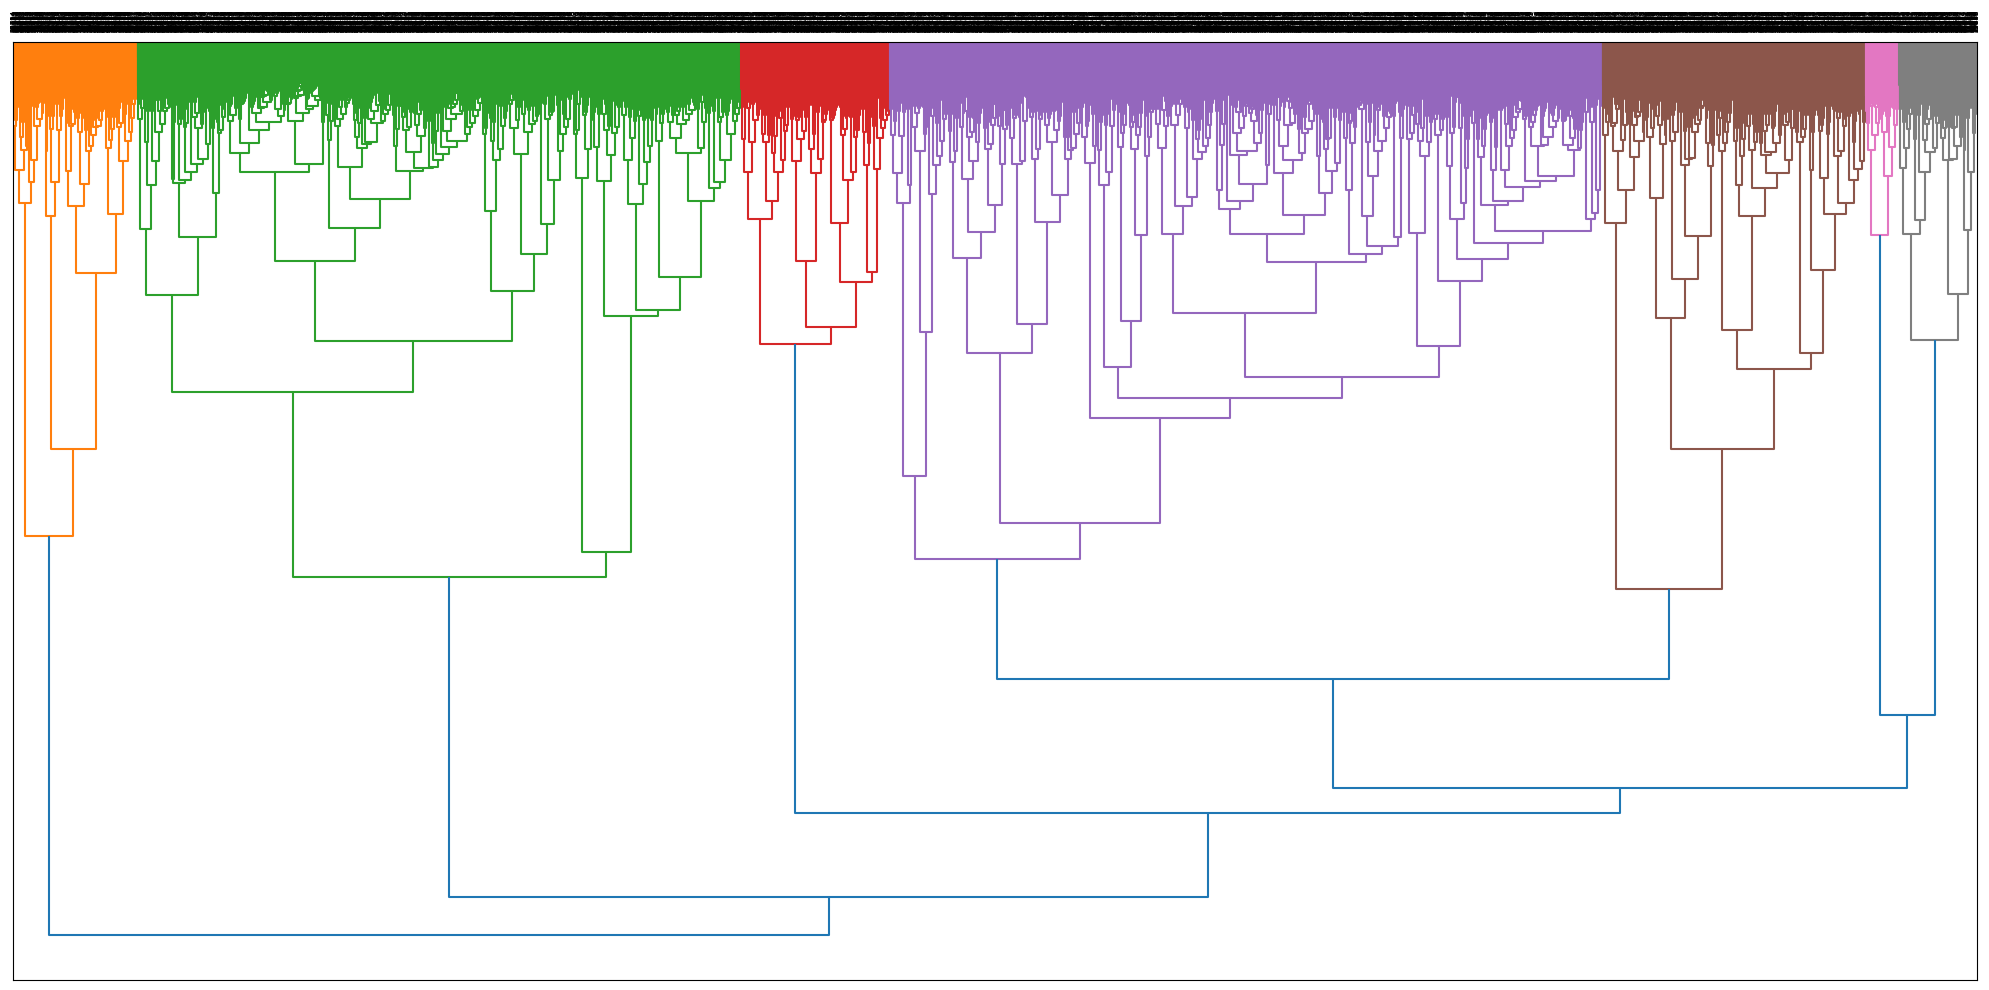

In [12]:
# Plot the dendrogram : * TAKES ABOUT A MINUTE *
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

fig, ax = plt.subplots(figsize=(20, 10))
ax = dendrogram(linkage_matrix, orientation="bottom", labels=abstracts_str[random_indices].index)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.tight_layout()
plt.show()


## 4.3  Silhouette Method for Optimum Number of Topic Clusters   
Find the optimum number of ML topics using the Silhouetter methid from sklearn  

Number of clusters: 3, Silhouette score: 0.008403356616917771
Number of clusters: 4, Silhouette score: 0.015044920595958772
Number of clusters: 5, Silhouette score: 0.01963325168165996
Number of clusters: 6, Silhouette score: 0.02495437567735529
Number of clusters: 7, Silhouette score: 0.02397593474878027
Number of clusters: 8, Silhouette score: 0.025747845735689442
Number of clusters: 9, Silhouette score: 0.011761350425433371
Number of clusters: 10, Silhouette score: 0.01514088243017888
Number of clusters: 11, Silhouette score: 0.01471969740939275
Number of clusters: 12, Silhouette score: 0.014544078571891864
Number of clusters: 13, Silhouette score: 0.016730964054021233
Number of clusters: 14, Silhouette score: 0.019214297172423435
The best number of clusters is 8 with a silhouette score of 0.025747845735689442


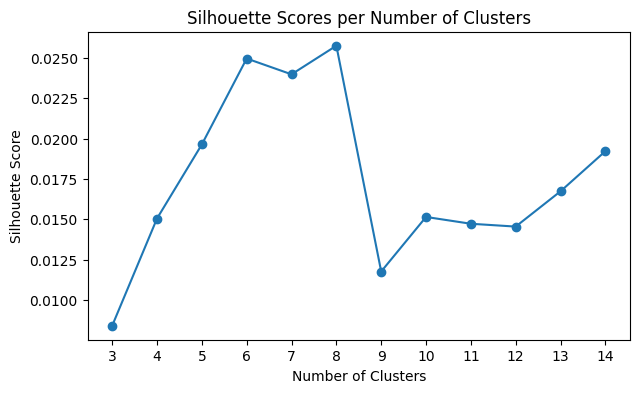

In [13]:
from scipy.cluster.hierarchy import fcluster, linkage
from sklearn.metrics import silhouette_score

# Range of number of clusters to try
cluster_range = range(3, 15)

# Initialize variables to store the results
best_num_clusters = 0
best_score = -1
silhouette_scores = []

for num_clusters in cluster_range:
    # Generate cluster labels
    clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
    # Compute the silhouette score
    score = silhouette_score(distance_matrix, clusters, metric='euclidean')
    print(f"Number of clusters: {num_clusters}, Silhouette score: {score}")
    # Store the score
    silhouette_scores.append(score)
    # Update the best score and best number of clusters
    if score > best_score:
        best_score = score
        best_num_clusters = num_clusters

print(f"The best number of clusters is {best_num_clusters} with a silhouette score of {best_score}")

# Plotting the silhouette scores
plt.figure(figsize=(7, 4))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores per Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(list(cluster_range))
plt.grid(False)
plt.show()


# 5. The Machine Learning Topic of Greatest Interest in 2023  

## 5.1 LDA Assuming 8 Topics  
Using the output of the agglomerative hierarchical clustering, the LDA model is run again now assuming 8 topics.  

In [14]:
# Run the LDA model again - this time assume 8 main topics following the results from hierarchical agglomerative clustering
num_topics = 8
passes = 10
lda_model_8 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes, random_state=123)
for idx, topic in lda_model_8.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.021*"polici" + 0.016*"agent" + 0.014*"reinforc" + 0.014*"environ" + 0.014*"control" + 0.012*"rl" + 0.010*"approach" + 0.010*"system" + 0.010*"reward" + 0.009*"task"
Topic: 1 
Words: 0.019*"imag" + 0.013*"predict" + 0.012*"detect" + 0.009*"time" + 0.008*"featur" + 0.007*"segment" + 0.007*"base" + 0.007*"deep" + 0.007*"approach" + 0.006*"anc"
Topic: 2 
Words: 0.031*"network" + 0.024*"neural" + 0.015*"ing" + 0.012*"gener" + 0.010*"deep" + 0.009*"comput" + 0.007*"approach" + 0.007*"architectur" + 0.007*"function" + 0.006*"process"
Topic: 3 
Words: 0.016*"attack" + 0.012*"machin" + 0.011*"system" + 0.011*"adversari" + 0.010*"predict" + 0.010*"user" + 0.008*"provid" + 0.008*"ml" + 0.008*"studi" + 0.008*"research"
Topic: 4 
Words: 0.024*"ing" + 0.016*"task" + 0.015*"anc" + 0.014*"label" + 0.013*"gener" + 0.011*"featur" + 0.010*"represent" + 0.010*"sampl" + 0.010*"improv" + 0.009*"domain"
Topic: 5 
Words: 0.034*"graph" + 0.016*"network" + 0.011*"node" + 0.009*"commun" + 0.00

## 5.2 Estimate Number of Abstracts per Topic over 2023  (8 Topics)  

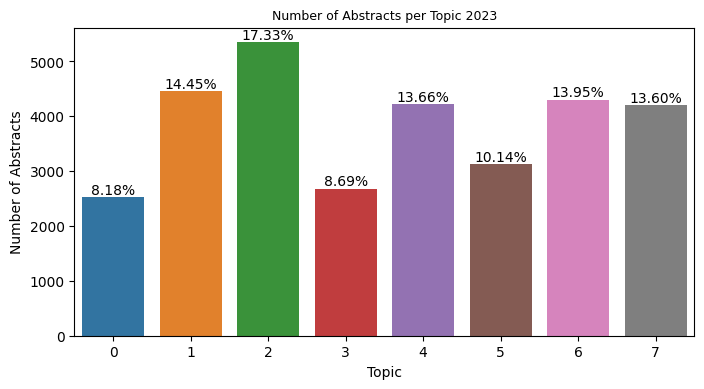

In [16]:

# Get topic distributions of the abstracts for the new 8 topic LDA model 
total_abstracts, df_topic_counts, dominant_topics = topic_distribution(lda_model_8)

fig, ax = plt.subplots(figsize=(8, 4))  # Create a figure and a single axis
bar_plot_8 = sns.barplot(x='Topic', y='Num_Documents', data=df_topic_counts, ax=ax)
bar_plot_8.grid(False)
ax.set_title('Number of Abstracts per Topic 2023', fontsize=9)
ax.set_xlabel('Topic')
ax.set_ylabel('Number of Abstracts')

# Annotate bars with the percentage
for p in bar_plot_8.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height() / total_abstracts)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    bar_plot_8.annotate(percentage, (x, y), ha='center', va='bottom')

plt.show()

## 5.3 Show Top 10 Words for each of the 8 Topic Distributions  

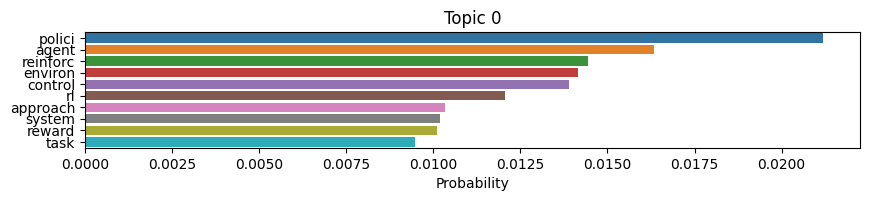

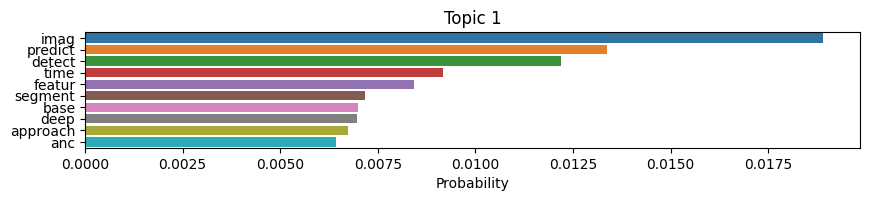

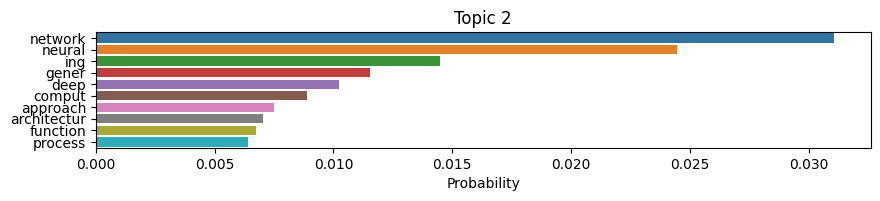

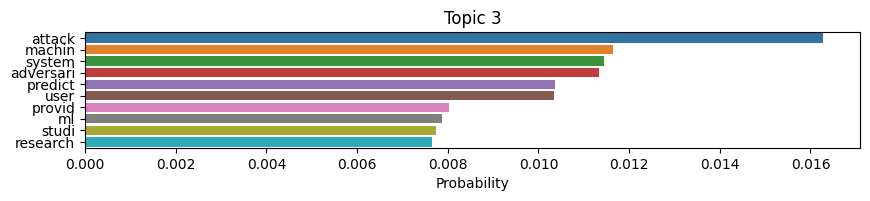

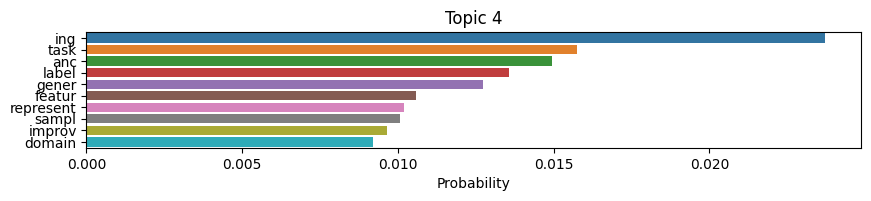

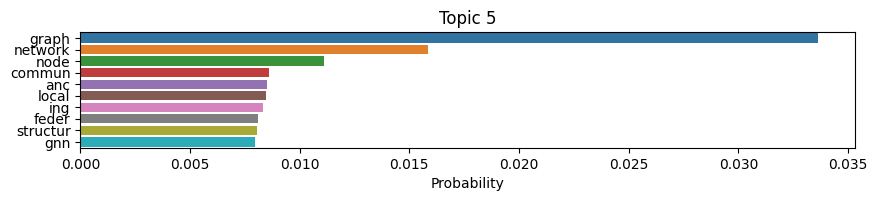

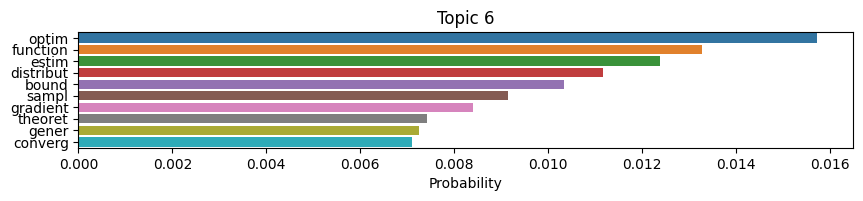

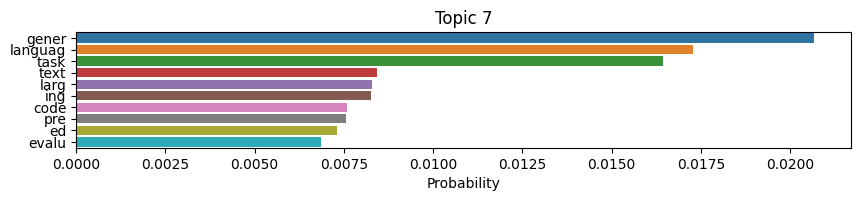

In [17]:
top_words_per_topic = []
for t in range(lda_model_8.num_topics):
    top_words_per_topic.extend([(t, ) + x for x in lda_model_8.show_topic(t, topn = 10)])

df_top_words = pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'Probability'])

for i in range(lda_model_8.num_topics):
    fig, ax = plt.subplots(figsize=(10, 1.5))  # Adjust size as needed
    topic_words = df_top_words.loc[df_top_words['Topic'] == i]
    sns.barplot(x='Probability', y='Word', data=topic_words, ax=ax)
    ax.set_title(f'Topic {i}')
    ax.set_xlabel('Probability')
    ax.set_ylabel('')
    plt.show()

## 5.4 Identifying Topic Structure (Word Clouds)  
The top words per topic are now starting to show some sort of 'identity'. For instance Topic 7 looks like it is related to Large language Models (LLM). 

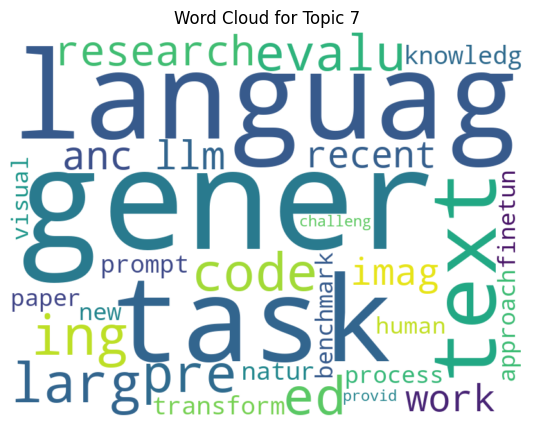

In [18]:
from wordcloud import WordCloud

def create_word_cloud(lda_model, topic_number, num_words, dictionary):
    # Extract the word distribution for the specified topic
    topic_words = {dictionary[id]: value for id, value in lda_model.get_topic_terms(topic_number, topn=num_words)}

    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=600, background_color='white').generate_from_frequencies(topic_words)

    # Plotting the WordCloud
    plt.figure(figsize=(8, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Topic {topic_number }')
    plt.show()

n_words, topic = 30, 7
create_word_cloud(lda_model_8, topic_number=topic, num_words=n_words, dictionary=dictionary)


## 5.5 Defining Machine Learning 'Model' Definitions  
Previously in section 1.2 we had defined 3 Machine Learning approaches/definitions.  
Now we define 8 machine Learning 'model' type definitions as possible mappings of the LDA topics.  

In [19]:
# Wikipedia 'definitions' of main ML approaches 
wiki_llm_tok = preprocess(wiki_main_ml_models.loc[wiki_main_ml_models['ml_type'] == 'llm', 'topic'])
wiki_ann_tok = preprocess(wiki_main_ml_models.loc[wiki_main_ml_models['ml_type'] == 'ann', 'topic'])
wiki_dtree_tok = preprocess(wiki_main_ml_models.loc[wiki_main_ml_models['ml_type'] == 'dtree', 'topic'])
wiki_svm_tok = preprocess(wiki_main_ml_models.loc[wiki_main_ml_models['ml_type'] == 'svm', 'topic'])
wiki_regr_tok = preprocess(wiki_main_ml_models.loc[wiki_main_ml_models['ml_type'] == 'regr', 'topic'])
wiki_bayes_tok = preprocess(wiki_main_ml_models.loc[wiki_main_ml_models['ml_type'] == 'bayes', 'topic'])
wiki_gp_tok = preprocess(wiki_main_ml_models.loc[wiki_main_ml_models['ml_type'] == 'gp', 'topic'])
wiki_ga_tok = preprocess(wiki_main_ml_models.loc[wiki_main_ml_models['ml_type'] == 'ga', 'topic'])
wiki_belief_tok = preprocess(wiki_main_ml_models.loc[wiki_main_ml_models['ml_type'] == 'belief', 'topic'])
wiki_federated_tok = preprocess(wiki_main_ml_models.loc[wiki_main_ml_models['ml_type'] == 'federated', 'topic'])



## 5.6 Wikipedia ML Model Definition Mapping   
Using the models defined in Wikipedia : https://en.wikipedia.org/wiki/Machine_learning#Models  and https://en.wikipedia.org/wiki/Large_language_model  
Do we see a meaningful mapping ? 

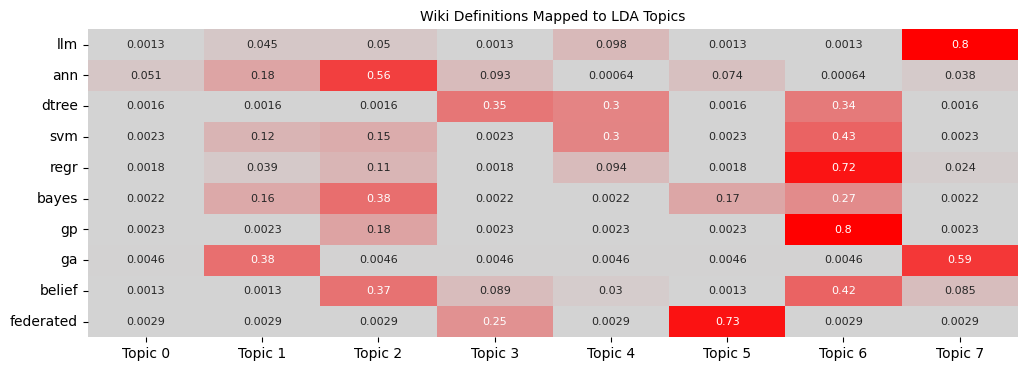

In [20]:
# Wikipedia 'definitions' of topics
wiki_model_defns = [wiki_llm_tok.iloc[0], wiki_ann_tok.iloc[0], wiki_dtree_tok.iloc[0], wiki_svm_tok.iloc[0], wiki_regr_tok.iloc[0], 
    wiki_bayes_tok.iloc[0], wiki_gp_tok.iloc[0], wiki_ga_tok.iloc[0], wiki_belief_tok.iloc[0], wiki_federated_tok.iloc[0]]
# Initialize an empty matrix to store topic probabilities
topic_matrix_wiki = get_topic_distribution(lda_model_8, wiki_model_defns, lda_model_8.num_topics)

# Plot a Heatmap 
row_labels = ['llm', 'ann', 'dtree', 'svm', 'regr', 'bayes', 'gp', 'ga', 'belief', 'federated']
col_labels = [f'Topic {i}' for i in range(lda_model_8.num_topics)]
# Define a color map from light grey to red
cmap = LinearSegmentedColormap.from_list('grey_red', ['lightgrey', 'red'])
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
sns.heatmap(topic_matrix_wiki, annot=True, cmap=cmap, xticklabels=col_labels, yticklabels=row_labels, cbar=False, annot_kws={"size": 8}, ax=axes)
axes.set_title('Wiki Definitions Mapped to LDA Topics', fontsize=10)
axes.tick_params(axis='x', labelrotation=0, labelsize=10)
axes.tick_params(axis='y', labelsize=10)